# Libraries

In [1]:
import os  # Для работы с файловой системой
import sep  # Для извлечения и анализа источников на астрономических изображениях
import pandas as pd  # Для работы с таблицами данных
import matplotlib.pyplot as plt  # Для построения графиков и визуализации данных
from astropy.io import fits  # Для чтения и записи FITS файлов, стандартного формата астрономических данных
from astropy.wcs import WCS  # Для работы с мировой координатной системой (WCS) в астрономических изображениях
from matplotlib.patches import Circle  # Для рисования кругов на графиках
import numpy as np  # Для работы с массивами чисел и выполнения численных операций
from scipy.stats import norm  # Для работы со статистическим нормальным распределением
from astropy.stats import sigma_clipped_stats  # Для расчета статистик с исключением выбросов (сигма-клиппинг)
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Для создания делимых областей на графиках
from concurrent.futures import ThreadPoolExecutor  # Для параллельного выполнения задач
from astropy.visualization import ZScaleInterval, MinMaxInterval  # Для масштабирования изображений

# Functions

In [14]:
def subtract_background(fits_file, output_directory, bw, bh, fw, fh, data=None, header=None):
    """
    Выполняет вычитание фона из данных FITS файла и сохраняет результат.

    Параметры:
    fits_file : str
        Путь к входному FITS файлу.
    output_directory : str
        Путь к выходному каталогу для сохранения обработанных файлов.
    bw : int
        Ширина блока для оценки фона.
    bh : int
        Высота блока для оценки фона.
    fw : int
        Ширина фильтра для сглаживания фона.
    fh : int
        Высота фильтра для сглаживания фона.

    Возвращаемые значения:
    data_sub : ndarray
        Данные с вычитанным фоном.
    bkg : sep.Background
        Объект фона.
    header : astropy.io.fits.Header
        Заголовок FITС файла.
    """
    print(f"Processing file: {fits_file}")
    if data is None:
        with fits.open(fits_file) as hdul:
            data = hdul[0].data
            header = hdul[0].header
        
    file_name = fits_file.split("/")[-1].replace(".fits", "").replace(".fit", "")
    if data is None or data.size == 0:
        print(f"Warning: No data in FITС file {fits_file}")
        return None, None, None

    print(f"Original byte order: {data.dtype.byteorder}")

    data = data.astype(np.float32)
    
    bkg = sep.Background(data, bw=bw, bh=bh, fw=fw, fh=fh)
    data_sub = data - bkg
    
    mean_data, median_data, std_data = sigma_clipped_stats(data, sigma=3.0)
    mean_data_sub, median_data_sub, std_data_sub = sigma_clipped_stats(data_sub, sigma=3.0)
    mean_bkg, median_bkg, std_bkg = sigma_clipped_stats(bkg.back(), sigma=3.0)
    
    # Создание фигуры и осей
    fig, axs = plt.subplots(1, 3, figsize=(15, 3))
    
    # Initial frame
    axs[0].hist(data.ravel(), bins=256, histtype='step', color='black')
    axs[0].axvline(x=mean_data, color='r', linestyle='--', label=f'Mean: {mean_data:.1f}')
    axs[0].axvline(x=mean_data + std_data, color='g', linestyle='--', label=f'STD: {std_data:.1f}')
    axs[0].axvline(x=mean_data - std_data, color='g', linestyle='--')
    axs[0].set_xlim([mean_data - 5*std_data, mean_data + 5*std_data])
    axs[0].set_title('Initial frame')
    axs[0].set_xlabel('Pixel Value')
    axs[0].set_ylabel('Frequency')
    axs[0].legend(loc="upper right")
    
    # Background
    axs[1].hist(bkg.back().ravel(), bins=256, histtype='step', color='black')
    axs[1].axvline(x=mean_bkg, color='r', linestyle='--', label=f'Mean: {mean_bkg:.1f}')
    axs[1].axvline(x=mean_bkg + std_bkg, color='g', linestyle='--', label=f'STD: {std_bkg:.1f}')
    axs[1].axvline(x=mean_bkg - std_bkg, color='g', linestyle='--')
    axs[1].set_xlim([mean_bkg - 5*std_data, mean_bkg + 5*std_data])
    axs[1].set_title('Background')
    axs[1].set_xlabel('Pixel Value')
    axs[1].set_ylabel('Frequency')
    axs[1].legend(loc="upper right")
    
    # Distribution with X-Limits after subtraction
    axs[2].hist(data_sub.ravel(), bins=256, histtype='step', color='black')
    axs[2].axvline(x=mean_data_sub, color='r', linestyle='--', label=f'Mean: {mean_data_sub:.1f}')
    axs[2].axvline(x=mean_data_sub + std_data_sub, color='g', linestyle='--', label=f'STD: {std_data_sub:.1f}')
    axs[2].axvline(x=mean_data_sub - std_data_sub, color='g', linestyle='--')
    axs[2].set_xlim([mean_data_sub - 5*std_data_sub, mean_data_sub + 5*std_data_sub])
    axs[2].set_title('Distribution after subtraction')
    axs[2].set_xlabel('Pixel Value')
    axs[2].set_ylabel('Frequency')
    axs[2].legend(loc="upper right")
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f'{file_name}_pix_distrib.png'), dpi=300)
    plt.show()

    # Построение изображений с правильными размерами colorbar
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Первое изображение
    img0 = axs[0].imshow(data, cmap='gray', origin='lower')
    axs[0].set_title('Initial data')
    divider0 = make_axes_locatable(axs[0])
    cax0 = divider0.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img0, cax=cax0)
    
    # Второе изображение
    img1 = axs[1].imshow(data_sub, cmap='gray', origin='lower')
    axs[1].set_title('Data after Background Subtraction')
    divider1 = make_axes_locatable(axs[1])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img1, cax=cax1)
    
    # Третье изображение
    img2 = axs[2].imshow(bkg.back(), cmap='gray', origin='lower')
    axs[2].set_title('Background')
    divider2 = make_axes_locatable(axs[2])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img2, cax=cax2)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f'{file_name}_sub_comparison.png'), dpi=300)
    plt.show()

    return data_sub, bkg, header

def evaluate_background_params(data, bw, bh, fw, fh):
    """
    Оценивает параметры фона для данных.
    """
    bkg = sep.Background(data, bw=bw, bh=bh, fw=fw, fh=fh)
    return bkg.globalrms, (bw, bh, fw, fh)

def find_best_background_params(fits_file, output_directory, data=None):
    """
    Находит наилучшие параметры для вычитания фона и строит график зависимости ошибки от параметров.
    """
    if data is None:
        with fits.open(fits_file) as hdul:
            data = hdul[0].data.astype(np.float32)
        
    file_name = fits_file.split("/")[-1].replace(".fits", "").replace(".fit", "")
    
    bw_values = [32, 64, 128]
    fw_values = [3, 5, 7]

    best_rms = np.inf
    best_params = None
    all_results = []

    with ThreadPoolExecutor() as executor:
        futures = []
        for bw in bw_values:
            for fw in fw_values:
                futures.append(executor.submit(evaluate_background_params, data, bw, bw, fw, fw))

        for future in futures:
            rms, params = future.result()
            all_results.append((rms, params))
            if rms < best_rms:
                best_rms = rms
                best_params = params

    # Построение графика зависимости ошибки от параметров
    rms_values = [result[0] for result in all_results]
    param_values = [f'bw={result[1][0]}, fw={result[1][2]}' for result in all_results]

    best_index = rms_values.index(best_rms)

    plt.figure(figsize=(8, 4))
    plt.plot(param_values, rms_values, 'o-', label='All parameters')
    plt.plot(param_values[best_index], rms_values[best_index], 'r*', label='Best parameter', markersize=15)
    plt.xticks(rotation=45)
    plt.xlabel('Parameters (bw, fw)')
    plt.ylabel('Global RMS Error')
    plt.title('Error vs Parameters')
    plt.legend()
    plt.tight_layout()
    plt.grid(alpha=0.25,lw=1,ls="-")
    plt.savefig(os.path.join(output_directory, f'{file_name}_error_vs_params.png'))
    plt.show()

    return best_params, all_results

def process_directory(directory, output_directory, circle_radius=10, scale='zscale'):
    """
    Обрабатывает все FITС файлы в указанном каталоге, выполняя вычитание фона и извлечение объектов.
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for filename in os.listdir(directory):
        if filename.endswith('.fit') or filename.endswith('.fits'):
            fits_file = os.path.join(directory, filename)
            with fits.open(fits_file) as hdul:
                data = hdul[0].data
                header = hdul[0].header
            data_v = remove_objects_and_correct_vignetting(fits_file, reduction_factor=50)
            best_params, all_results = find_best_background_params(fits_file, output_directory, data=data_v)
            if best_params is not None:
                bw, bh, fw, fh = best_params
                data_sub, bkg, header = subtract_background(fits_file, output_directory, bw, bh, fw, fh, data=data_v, header=header)
                if data_sub is not None:
                    objects_df = extract_and_export_objects(data_sub, bkg, header, output_directory, fits_file)
                    if df is not None:
                        base_name = os.path.splitext(filename)[0]
                        csv_filename = os.path.join(output_directory, f"{base_name}.csv")
                        objects_df.to_csv(csv_filename, index=False)

                        png_filename = os.path.join(output_directory, f"{base_name}.png")
                        plot_objects(data_sub, df.to_dict('records'), png_filename, scale)
                        with fits.open(fits_file) as hdul:
                            header = hdul[0].header


                        #radius = calc_frame_radius(header)
                        #match_obj_df = match_stars(header, objects_df, radius, max_dist=radius*.1)

def calc_frame_radius(header):                         

    # Создаем WCS объект
    wcs = WCS(header)
    
    # Определяем размер изображения
    naxis1 = header['NAXIS1']
    naxis2 = header['NAXIS2']
    
    # Получаем угловые координаты углов изображения
    corners = np.array([
        [0, 0],
        [0, naxis2 - 1],
        [naxis1 - 1, 0],
        [naxis1 - 1, naxis2 - 1]
    ])
    
    # Преобразуем координаты углов в экваториальные координаты (RA, Dec)
    ra_dec_corners = wcs.all_pix2world(corners, 1)
    ra_values = ra_dec_corners[:, 0]
    dec_values = ra_dec_corners[:, 1]
    
    # Определяем минимальные и максимальные значения по RA и Dec
    ra_min, ra_max = np.min(ra_values), np.max(ra_values)
    dec_min, dec_max = np.min(dec_values), np.max(dec_values)
    
    # Вычисляем разницу
    ra_diff = round(ra_max - ra_min,3)
    dec_diff = round(dec_max - dec_min,3)
    
    # Выбираем большее значение как радиус в градусах
    radius = max(ra_diff, dec_diff) / 2

    return radius

                        

def plot_objects(image_data, objects, output_image, scale='zscale'):
    """
    Визуализирует объекты на изображении и сохраняет результат в файл с возможностью выбора шкалы.

    Параметры:
    image_data : ndarray
        Данные изображения.
    objects : list
        Список объектов, извлеченных из изображения.
    output_image : str
        Путь к файлу для сохранения изображения.
    scale : str
        Шкала для отображения изображения (допустимые значения: 'linear', 'zscale', 'minmax').
    """
    from astropy.visualization import ZScaleInterval, MinMaxInterval

    if scale == 'zscale':
        interval = ZScaleInterval()
    elif scale == 'minmax':
        interval = MinMaxInterval()
    else:
        interval = None

    if interval:
        vmin, vmax = interval.get_limits(image_data)
    else:
        vmin, vmax = 0, np.percentile(image_data, 99)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)

    for obj in objects:
        # Проверка наличия ключей 'a' и 'b'
        if 'a' in obj and 'b' in obj:
            radius = 3 * np.sqrt(obj['a'] * obj['b'])  # Расчет радиуса на основе полуосей объекта
        else:
            radius = 10  # Если нет параметров 'a' и 'b', использовать фиксированный радиус

        e = Circle((obj['x'], obj['y']), radius=radius, edgecolor='green', facecolor='none', lw=.8)
        ax.add_patch(e)

    ax.axis('off')  # Отключает оси
    plt.savefig(output_image, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

def extract_and_export_objects(data_sub, bkg, header, output_directory, fits_file):
    """
    Извлекает объекты из данных с вычитанным фоном и сохраняет их параметры в CSV файл.

    Параметры:
    data_sub : ndarray
        Данные с вычитанным фоном.
    bkg : sep.Background
        Объект фона.
    header : astropy.io.fits.Header
        Заголовок FITС файла.
    output_directory : str
        Путь к выходному каталогу для сохранения обработанных файлов.
    fits_file : str
        Путь к исходному FITС файлу для сохранения имени.

    Возвращаемые значения:
    df : pandas.DataFrame
        Таблица с параметрами объектов.
    """
    if data_sub is None or bkg is None or header is None:
        print("Invalid input data.")
        return None

    thresh = 5.0
    minarea = 20
    err = bkg.globalrms

    deblend_nthresh = 32
    deblend_cont = 0.05
    clean = True
    clean_param = 1.0
    
    sep.set_extract_pixstack(1e7) 
    
    objects = sep.extract(data_sub, thresh, err=err, minarea=minarea, deblend_nthresh=deblend_nthresh,
                          deblend_cont=deblend_cont, clean=clean, clean_param=clean_param)

    if len(objects) == 0:
        print(f"No objects found in {fits_file}")
        return None
    else:
        print(f"{len(objects)} objects found in {fits_file}")

    wcs = WCS(header)
    objects_coords = wcs.all_pix2world(objects['x'], objects['y'], 1)

    flux, flux_err, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=err, gain=1.0)
    mag = -2.5 * np.log10(flux)
    mag_err = 2.5 / np.log(10) * (flux_err / flux)

    data = {
        'id': range(len(objects)),
        'x': objects['x'],
        'y': objects['y'],
        'ra': objects_coords[0],
        'dec': objects_coords[1],
        'flux': flux,
        'flux_err': flux_err,
        'mag': mag,
        'mag_err': mag_err,
        'flag': flag
    }

    # Добавление параметров 'a' и 'b' в таблицу объектов
    if 'a' in objects.dtype.names and 'b' in objects.dtype.names:
        data['a'] = objects['a']
        data['b'] = objects['b']

    df = pd.DataFrame(data)

    base_name = os.path.splitext(os.path.basename(fits_file))[0]
    output_csv_file = os.path.join(output_directory, f"{base_name}_objects.csv")
    df.to_csv(output_csv_file, index=False)

    return df


# Сопоставление координат звезд из FITS-файла с каталогом Gaia
def match_stars(header, objects_df, radius):
    
    # Пример запроса к каталогу Gaia для заданной области неба
    query = """
    SELECT TOP 1000000
        source_id, ra, dec, pmra, pmdec, parallax
    FROM gaiadr3.gaia_source
    WHERE CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {ra}, {dec}, {radius})
    ) = 1
    """
    if radius/10 > 1/360:
        max_dist = 1/360 # 10 arcsec
    else:
        max_dist=radius*.1
    
    # Используем центральные координаты вашего изображения и радиус
    ra_center = header['CRVAL1']
    dec_center = header['CRVAL2']
    radius = round(radius,1)  # Радиус области в градусах
    
    # Выполняем запрос
    job = Gaia.launch_job(query.format(ra=ra_center, dec=dec_center, radius=radius))
    gaia_data = job.get_results()
    
    # Преобразуем данные в DataFrame для удобства
    gaia_df = gaia_data.to_pandas()
    
    matches = []
    for index, star in objects_df.iterrows():
        ra, dec = star['ra'], star['dec']
        distances = np.sqrt((gaia_df['ra'] - ra)**2 + (gaia_df['dec'] - dec)**2)
        min_dist = distances.min()
        if min_dist < max_dist:
            matched_star = gaia_df.iloc[distances.idxmin()]
            matches.append({
                'x': star['x'],
                'y': star['y'],
                'ra_diff': ra - matched_star['ra'],
                'dec_diff': dec - matched_star['dec']
            })
            
    return pd.DataFrame(matches)


In [47]:
def vignetting_model(coords, c0, c1, c2, c3, c4, c5):
    x, y = coords
    return c0 + c1*x + c2*y + c3*x*y + c4*x**2 + c5*y**2

def correct_vignetting(data, reduction_factor=50):
    small_data = data[::reduction_factor, ::reduction_factor]
    x = np.arange(small_data.shape[1])
    y = np.arange(small_data.shape[0])
    X, Y = np.meshgrid(x, y)
    coords = np.vstack((X.ravel(), Y.ravel()))
    data_flat = small_data.ravel()
    
    params, _ = curve_fit(vignetting_model, coords, data_flat, p0=[np.median(small_data), 0, 0, 0, 0, 0])
    
    full_x = np.arange(data.shape[1])
    full_y = np.arange(data.shape[0])
    full_X, full_Y = np.meshgrid(full_x, full_y)
    
    vignetting_0 = vignetting_model((full_X, full_Y), *params)
    
    vignetting_0 = vignetting_0 + abs(np.min(vignetting_0))
    vignetting_pos = np.nan_to_num(vignetting_0, nan=0.1, posinf=65535, neginf=0.1)
    vignetting_pos= np.clip(vignetting_pos, 0.1, 65535)
    vignetting = vignetting_pos/np.max(vignetting_pos)

    print("Params: ", params)
    print("Vignetting min: ", np.min(vignetting))
    print("Vignetting max: ", np.max(vignetting))
    print("Vignetting mean: ", np.mean(vignetting))
    
    plt.figure()
    plt.hist(vignetting.ravel(), bins=256, histtype='step', color='black')
    corrected_data = data / vignetting
    corrected_data = np.clip(corrected_data, 0.1, 65535)
    plt.figure()
    plt.hist(corrected_data.ravel(), bins=256, histtype='step', color='black')
        # Диагностика значений модели виньетирования

    # Удаление бесконечных и NaN значений
    
    
    return corrected_data, vignetting

def rmse(image1, image2):
    return np.sqrt(np.mean((image1 - image2) ** 2))

def remove_objects_and_correct_vignetting(fits_file, reduction_factor=50):
    with fits.open(fits_file) as hdul:
        data = hdul[0].data.astype(float)
        data = data.byteswap().newbyteorder()

    mean_data, median_data, std_data = sigma_clipped_stats(data, sigma=3.0)
    
    objects = sep.extract(data - median_data, 1.5, err=std_data)
    
    for obj in objects:
        x, y = int(obj['x']), int(obj['y'])
        data[max(0, y-5):y+6, max(0, x-5):x+6] = median_data

    corrected_data, vignetting = correct_vignetting(data, reduction_factor)

    mean_corrected, median_corrected, std_corrected = sigma_clipped_stats(corrected_data, sigma=3.0)
    mean_vignetting, median_vignetting, std_vignetting = sigma_clipped_stats(vignetting, sigma=3.0)

    rmse_before = rmse(data, vignetting)
    rmse_after = rmse(corrected_data, vignetting)

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    axs[0, 0].imshow(data, cmap='gray', interpolation='nearest')
    axs[0, 0].set_title("До коррекции виньетирования")
    
    axs[0, 1].imshow(vignetting, cmap='gray', interpolation='nearest')
    axs[0, 1].set_title("Модель виньетирования")
    
    axs[0, 2].imshow(corrected_data, cmap='gray', interpolation='nearest')
    axs[0, 2].set_title("После коррекции виньетирования")
    
    axs[1, 0].hist(data.ravel(), bins=256, histtype='step', color='black')
    axs[1, 0].axvline(x=mean_data, color='r', linestyle='--', label=f'Mean: {mean_data:.1f}')
    axs[1, 0].axvline(x=mean_data + std_data, color='g', linestyle='--', label=f'STD: {std_data:.1f}')
    axs[1, 0].axvline(x=mean_data - std_data, color='g', linestyle='--')
    axs[1, 0].set_xlim([mean_data - 5*std_data, mean_data + 5*std_data])
    axs[1, 0].set_title('Initial frame')
    axs[1, 0].set_xlabel('Pixel Value')
    axs[1, 0].set_ylabel('Frequency')
    axs[1, 0].legend(loc="upper right")
    
    axs[1, 1].hist(vignetting.ravel(), bins=256, histtype='step', color='black')
    axs[1, 1].axvline(x=mean_vignetting, color='r', linestyle='--', label=f'Mean: {mean_vignetting:.1f}')
    axs[1, 1].axvline(x=mean_vignetting + std_vignetting, color='g', linestyle='--', label=f'STD: {std_vignetting:.1f}')
    axs[1, 1].axvline(x=mean_vignetting - std_vignetting, color='g', linestyle='--')
    axs[1, 1].set_xlim([mean_vignetting - 5*std_vignetting, mean_vignetting + 5*std_vignetting])
    axs[1, 1].set_title('Vignetting model')
    axs[1, 1].set_xlabel('Pixel Value')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].legend(loc="upper right")
    
    axs[1, 2].hist(corrected_data.ravel(), bins=256, histtype='step', color='black')
    axs[1, 2].axvline(x=mean_corrected, color='r', linestyle='--', label=f'Mean: {mean_corrected:.1f}')
    axs[1, 2].axvline(x=mean_corrected + std_corrected, color='g', linestyle='--', label=f'STD: {std_corrected:.1f}')
    axs[1, 2].axvline(x=mean_corrected - std_corrected, color='g', linestyle='--')
    axs[1, 2].set_xlim([mean_corrected - 5*std_corrected, mean_corrected + 5*std_corrected])
    axs[1, 2].set_title('Corrected frame')
    axs[1, 2].set_xlabel('Pixel Value')
    axs[1, 2].set_ylabel('Frequency')
    axs[1, 2].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

    print(f'RMSE before correction: {rmse_before}')
    print(f'RMSE after correction: {rmse_after}')

    return corrected_data

In [3]:
plt.rcParams.update({
    'figure.figsize': (8, 6),  # Размеры графиков
    'figure.dpi': 100,  # Разрешение графиков
    'savefig.dpi': 300,  # Разрешение сохраненных изображений
    'font.size': 12,  # Размер шрифта
    'font.family': 'serif',  # Семейство шрифтов
    'axes.labelsize': 14,  # Размер шрифта для подписей осей
    'axes.titlesize': 14,  # Размер шрифта для заголовков
    'xtick.labelsize': 12,  # Размер шрифта для подписей меток на оси X
    'ytick.labelsize': 12,  # Размер шрифта для подписей меток на оси Y
    'legend.fontsize': 10,  # Размер шрифта для легенды
    'lines.linewidth': 1,  # Толщина линий
    'lines.markersize': 6,  # Размер маркеров
    'axes.grid': False,  # Сетка на графиках
    'grid.alpha': 0.25,  # Прозрачность сетки
    'grid.linestyle': '--',  # Стиль линии сетки
    'grid.color': 'gray',  # Цвет сетки
    'axes.axisbelow': True,  # Сетка ниже данных
    'image.cmap': 'viridis',  # Цветовая карта для изображений
    'errorbar.capsize': 3,  # Размер "колпачков" на графиках ошибок
    "legend.loc": 'best', 
})

# Implementation

In [8]:
# Укажи путь к директории с FITS файлами и директории для сохранения результатов
fits_directory = os.getcwd() + '/data/'
output_directory = os.getcwd() + '/output/'
circle_radius = 10  # Радиус кружочков

Params:  [ 5.38267239e+04  1.13024605e+02  7.14005963e+01  1.07761694e+00
 -1.54696453e+00 -1.08512492e+00]
Vignetting min:  1.5259021896696423e-06
Vignetting max:  1.0
Vignetting mean:  0.9999993535983169


/tmp/ipykernel_142738/863735007.py:92: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[1, 1].set_xlim([mean_vignetting - 5*std_vignetting, mean_vignetting + 5*std_vignetting])


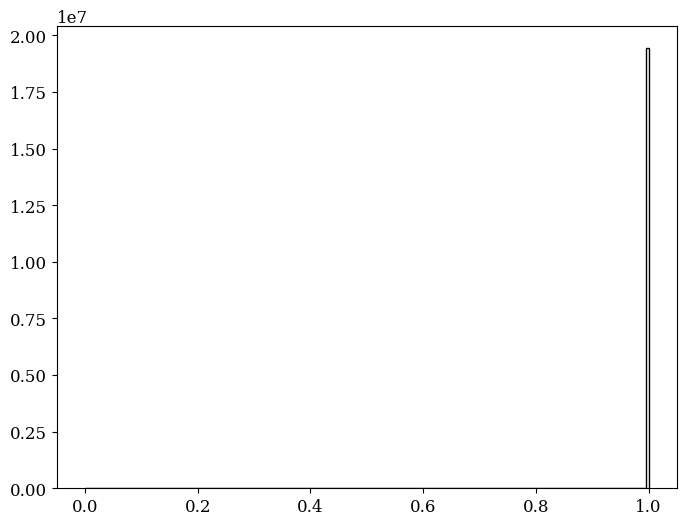

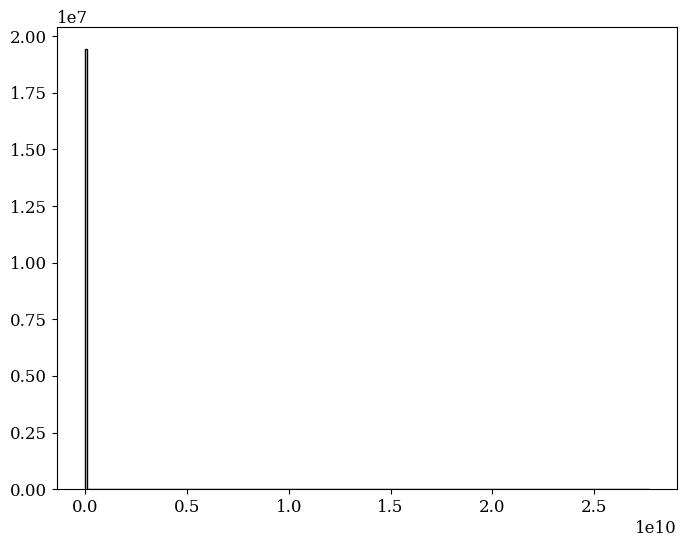

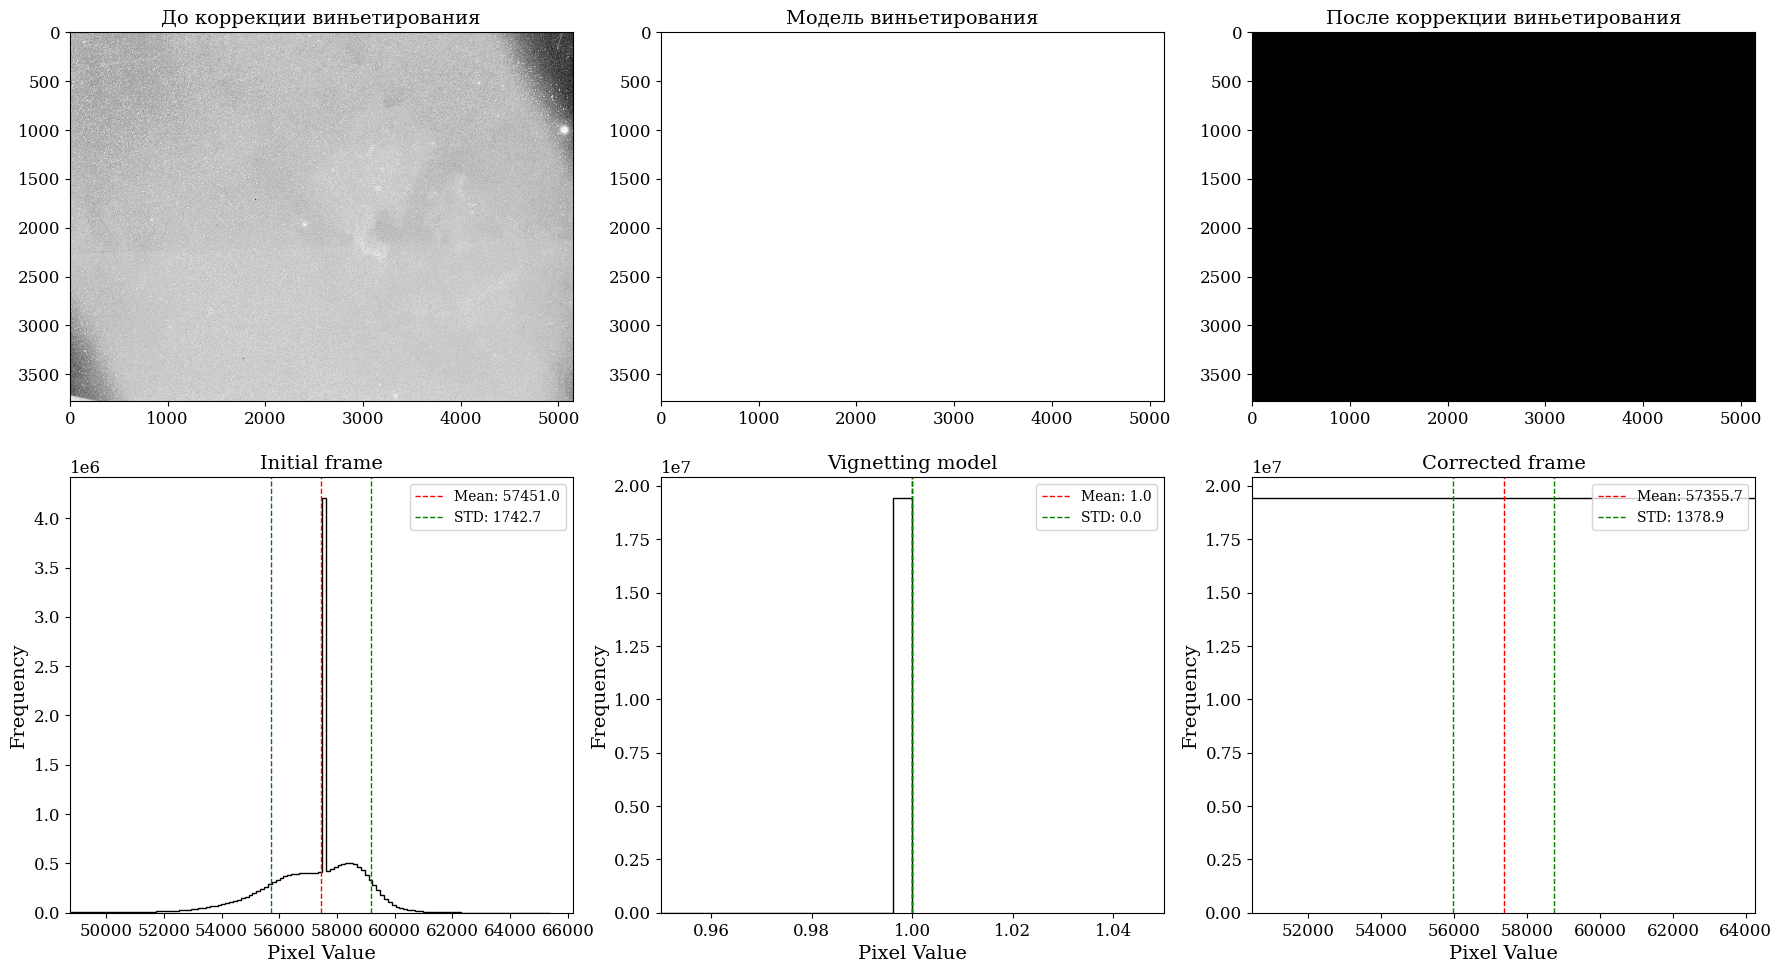

RMSE before correction: 56954.15034055283
RMSE after correction: 6277168.697106192


array([[5.56900000e+04, 5.42330000e+04, 5.41300000e+04, ...,
        7.81531000e+04, 1.61280492e+05, 2.76701877e+10],
       [5.75880000e+04, 5.75880000e+04, 5.75880000e+04, ...,
        6.37904419e+04, 1.12660428e+05, 4.55429021e+05],
       [5.75880000e+04, 5.75880000e+04, 5.75880000e+04, ...,
        5.53359533e+04, 9.13081152e+04, 2.21978604e+05],
       ...,
       [6.28460000e+04, 6.31830000e+04, 6.30900000e+04, ...,
        4.97400000e+04, 4.95940000e+04, 4.95210000e+04],
       [6.28230000e+04, 6.28630000e+04, 6.29710000e+04, ...,
        4.89930000e+04, 5.07410000e+04, 4.98790000e+04],
       [6.30650000e+04, 6.29770000e+04, 6.28650000e+04, ...,
        4.83570000e+04, 4.91770000e+04, 4.79060000e+04]])

In [46]:
remove_objects_and_correct_vignetting(fits_directory+"alf-Cyg_11-12.11.1985_40m_70S-1.fit", reduction_factor=50)

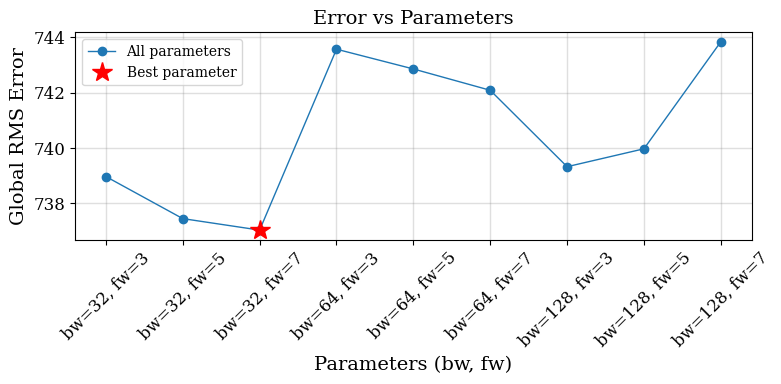

Processing file: /home/izm-ildana/astro/variable_search/data/alf-Cyg_11-12.11.1985_40m_70S-4.fit
Original byte order: =


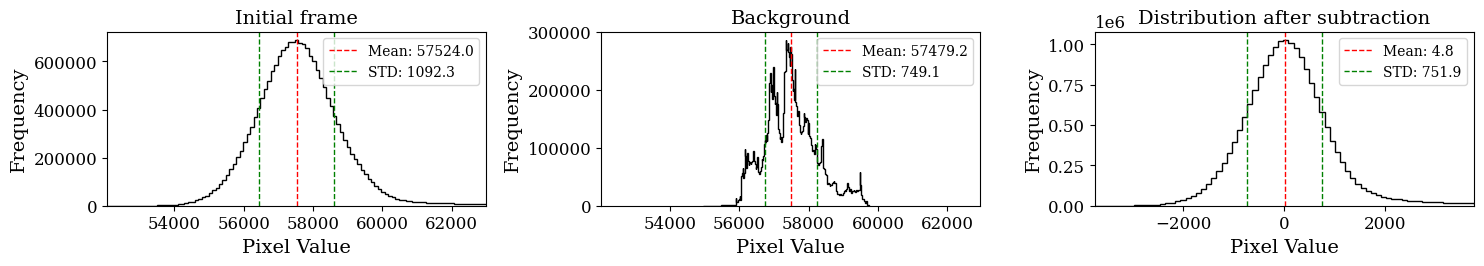

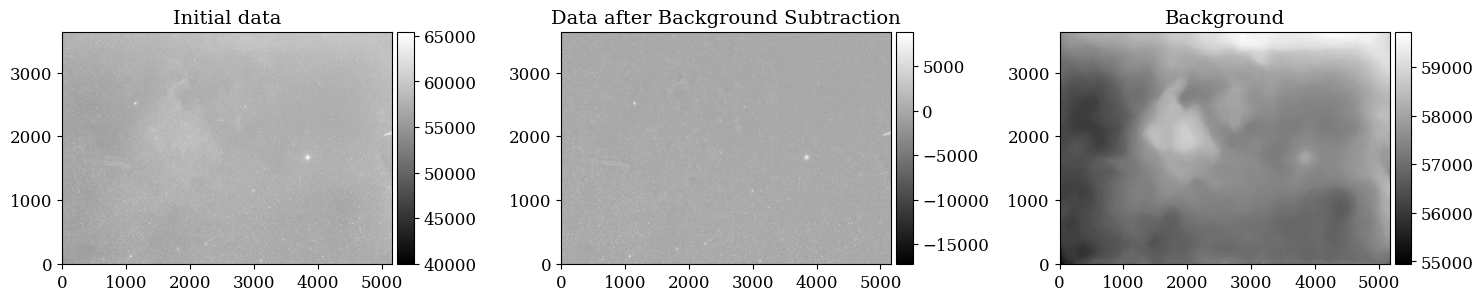

3042 objects found in /home/izm-ildana/astro/variable_search/data/alf-Cyg_11-12.11.1985_40m_70S-4.fit


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f4b8440f060> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x7f4b73370900> (for post_execute), with arguments args (),kwargs {}:


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f4bbff5f470>>
Traceback (most recent call last):
  File "/home/izm-ildana/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



In [9]:
process_directory(fits_directory, output_directory,scale='zscale')